In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train = pd.read_excel('C:/Users/User/Desktop/인공지능 프로젝트/데이터정제_1224.xlsx')

In [3]:
train.head()
train.columns

Index(['경기일자', 'KIA', 'LG', 'NC', 'SK', '넥센', '두산', '롯데', '삼성', '한화', '월', '화',
       '수', '목', '금', '토', '일', '공휴일', '1루', '3루', '외야', '중앙', '총관중수', '1루_d0',
       '1루_d1', '1루_d2', '1루_d3', '1루_d4', '1루_d5', '1루_d6', '1루_d7', '1루_d8',
       '1루_d9', '1루_d10', '1루_d11', '3루_d0', '3루_d1', '3루_d2', '3루_d3',
       '3루_d4', '3루_d5', '3루_d6', '3루_d7', '3루_d8', '3루_d9', '3루_d10',
       '3루_d11', '외야_d0', '외야_d1', '외야_d2', '외야_d3', '외야_d4', '외야_d5', '외야_d6',
       '외야_d7', '외야_d8', '외야_d9', '외야_d10', '외야_d11', '중앙_d0', '중앙_d1',
       '중앙_d2', '중앙_d3', '중앙_d4', '중앙_d5', '중앙_d6', '중앙_d7', '중앙_d8', '중앙_d9',
       '중앙_d10', '중앙_d11', '전체_d0', '전체_d1', '전체_d2', '전체_d3', '전체_d4',
       '전체_d5', '전체_d6', '전체_d7', '전체_d8', '전체_d9', '전체_d10', '전체_d11'],
      dtype='object')

In [4]:
X = train.loc[:,'KIA':'공휴일']
reserve = train.loc[:,'전체_d0':'전체_d11']  # 예매 데이터가 d- 형태로 되어있음
reserve = reserve.iloc[:,::-1]  # 예매 데이터를 반대로 해서 d+ 형태로 바꿔줌
X =  pd.concat([X,reserve],axis=1)
y = train['총관중수']

## 전체 관중수 예측

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [6]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
reserve = X.loc[:,'전체_d11':'전체_d0']
reserve_test = X_test.loc[:,'전체_d11':'전체_d0']

In [7]:
print(len(X))  # train set 개수
print(len(X_test))  # test set 개수

130
23


### 91개 모델 만들기

In [8]:
y_model = []
reserve_model = []
dic = {}
k=0
l=0

for i in range(0,12):
    feature = X.iloc[:,0:17+i]
    d = round(feature.shape[1]**0.5)
    y_model.append('rf_y'+str(i))
    y_model[l] = RandomForestRegressor(n_estimators=500, max_features=d, random_state=123)
    y_model[l].fit(feature,y)
    l = l+1
    for j in range(i,12):
        reserve_model.append('rf_'+str(i)+'_'+str(j))
        reserve_model[k] = RandomForestRegressor(n_estimators=500, max_features=d, random_state=123)
        dic.update({'rf_'+str(i)+'_'+str(j):reserve_model[k]})
        reserve_model[k].fit(feature,reserve.iloc[:,j])
        k = k+1
        
        val = 'd' + repr(i)
        X[val] = reserve.iloc[:,i]

### 다음날 예매량과 전체 관중수 예측 함수

In [9]:
def pred(data, reserve, idx):
    d = []
    e = []
    f = []
    for i in range(0,12):
        a = reserve.iloc[idx,:]  # 예매량 실제값
        b = []
        c = []
        k = 0
        sum = 0
        for j in range(i,12):
            b.append(dic['rf_'+str(i)+'_'+str(j)].predict(data.iloc[idx,0:17+i].values.reshape(1,-1)))  # 예매량 예측값
            val = (a.values[j]-b[k])**2
            k = k+1
            sum = sum+val
        mse = sum/(12-i)
        rmse = mse**0.5  # 예매량 RMSE
        
        print('예매량 예측')
        c = list(a.values[0:i])+b[0:12]  # 실제값이 생긴 예매량 반영한 예매량 예측값
        plt.plot(a.values,color='r')  # 예매량 실제값 plot(빨간색)
        plt.plot(c,color='g')  # 예매량 예측값 plot(초록색)
        plt.show()
        
        print('RMSE: ',rmse)
        
        pred = y_model[i].predict(data.iloc[idx,0:17+i].values.reshape(1,-1))  # 총관중수 예측값
        print('총관중수(예측): ',pred,'\n')
        
        d.append(y[idx])  # 실제 총관중수
        e.append(pred)  # 예측 총관중수
        f.append(d[i]-e[i])  # 예측오차
    
    print('총관중수 예측')
    fig=plt.figure(figsize=(14, 4))
    ax1=fig.add_subplot(1,2,1)
    ax2=fig.add_subplot(1,2,2)
    
    ax1.plot(d,color='r')  # 실제 총관중수 plot(빨간색)
    ax1.plot(e,color='g')  # 예측 총관중수 plot(초록색)
    ax2.plot(f)  # 예측오차 plot

예매량 예측


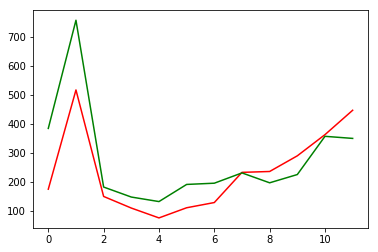

RMSE:  [105.37266586]
총관중수(예측):  [15754.9949381] 

예매량 예측


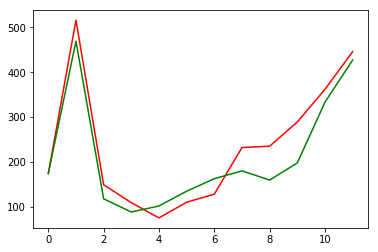

RMSE:  [46.74885276]
총관중수(예측):  [11598.0673] 

예매량 예측


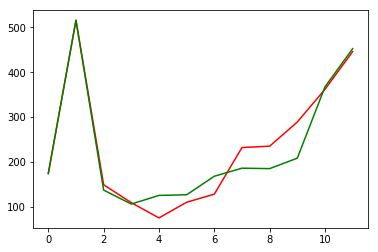

RMSE:  [39.69197791]
총관중수(예측):  [13279.664] 

예매량 예측


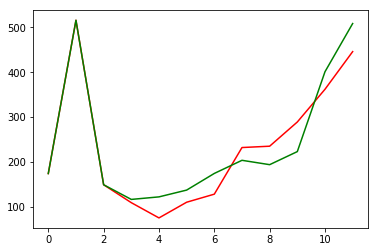

RMSE:  [44.03963425]
총관중수(예측):  [14313.466] 

예매량 예측


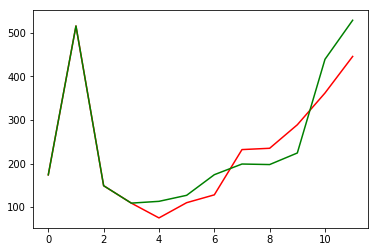

RMSE:  [54.2019932]
총관중수(예측):  [15020.062] 

예매량 예측


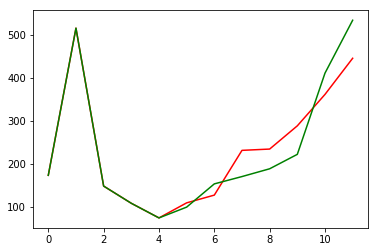

RMSE:  [55.07698626]
총관중수(예측):  [14224.472] 

예매량 예측


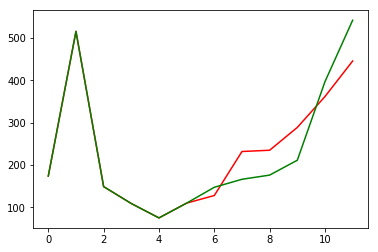

RMSE:  [64.14200932]
총관중수(예측):  [13743.622] 

예매량 예측


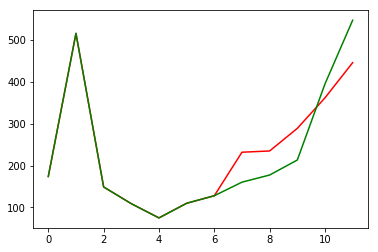

RMSE:  [71.44155352]
총관중수(예측):  [13570.104] 

예매량 예측


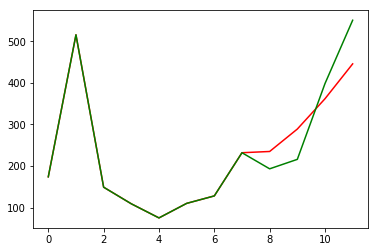

RMSE:  [69.7196651]
총관중수(예측):  [13823.684] 

예매량 예측


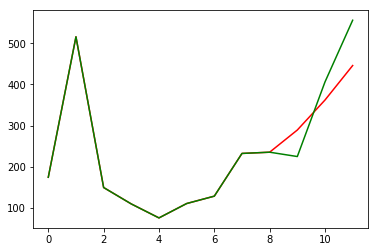

RMSE:  [78.04072264]
총관중수(예측):  [14010.044] 

예매량 예측


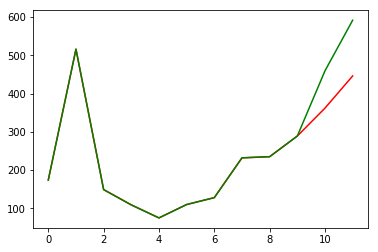

RMSE:  [123.86557608]
총관중수(예측):  [14084.504] 

예매량 예측


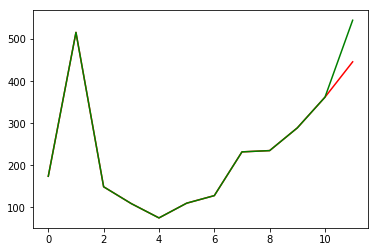

RMSE:  [98.856]
총관중수(예측):  [14015.606] 

총관중수 예측


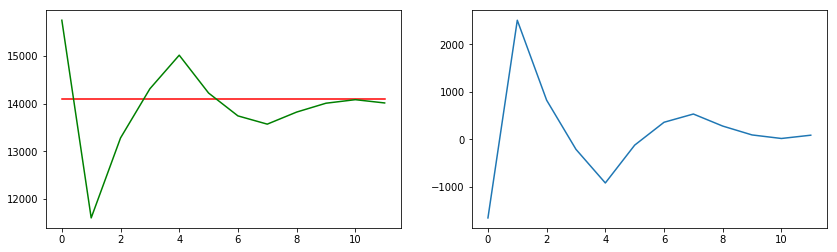

In [10]:
pred(X_test,reserve_test,4)  # test set 5번째 관측값에 대한 예측